In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

import time

import pickle

In [2]:
# On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

## Classification

In [3]:
# On charge nos données
df = pd.read_csv('data_preprocessed.csv')
df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
df.set_index('SK_ID_CURR', inplace=True)

In [4]:
df.columns

Index(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_CONT_MOBILE',
       ...
       'CC_NAME_CONTRACT_STATUS_Refused_SUM',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_COUNT'],
      dtype='object', length=573)

In [4]:
# On sépare en jeu de test et jeu d'entraînement
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [5]:
# On regarde l'équilibre de nos classes
train_df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [6]:
# On prépare nos folds
X = train_df.drop('TARGET', axis = 1)
y = train_df['TARGET']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
cv = folds.split(X, y)
cv = list(cv)

## Baseline

In [7]:
t0 = time.time()

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On sépare notre train en train et validation
for n_fold, (train_idx, valid_idx) in enumerate(cv):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    clf = XGBClassifier(booster='gblinear', random_state=24, use_label_encoder=False, eval_metric='logloss')
    clf.fit(train_x, train_y)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

t1 = time.time()
time_round = np.round(t1 - t0, 2)
print(f'Time : {time_round} secondes')

Fold  1 AUC : 0.765537
Fold  2 AUC : 0.771155
Fold  3 AUC : 0.766716
Fold  4 AUC : 0.772817
Fold  5 AUC : 0.764704
Time : 108.1 secondes


## Gestion des classes

In [8]:
results = []

In [9]:
scale_class = np.sqrt(df['TARGET'].value_counts()[0] / df['TARGET'].value_counts()[1])

In [10]:
t0 = time.time()

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On sépare notre train en train et validation
for n_fold, (train_idx, valid_idx) in enumerate(cv):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    clf = XGBClassifier(n_estimators=300, booster='gblinear', learning_rate=0.2, random_state=24,
                        scale_pos_weight=scale_class, use_label_encoder=False, eval_metric='logloss')
    clf.fit(train_x, train_y)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

    roc_score = roc_auc_score(valid_y, oof_preds[valid_idx])
    results.append(roc_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_score))

t1 = time.time()
time_round = np.round(t1 - t0, 2)
print(f'Time : {time_round} secondes')

Fold  1 AUC : 0.766143
Fold  2 AUC : 0.771758
Fold  3 AUC : 0.767230
Fold  4 AUC : 0.773105
Fold  5 AUC : 0.765840
Time : 241.03 secondes


In [11]:
round(np.mean(results), 4)

0.7688

## RandomizedSearch

In [12]:
model = XGBClassifier(scale_pos_weight=scale_class, booster='gblinear', random_state=24,
                      use_label_encoder=False, eval_metric='logloss')

params_xgbr = {'learning_rate' : (0.05, 0.10, 0.15, 0.20, 0.25), 'n_estimators' : [100, 250, 400, 500, 600]}

In [13]:
model_cv = RandomizedSearchCV(model, params_xgbr, verbose=1, cv=5, scoring='roc_auc')             

model_cv.fit(X, y)

# Meilleur paramètres du modèle
best_hyperparam = model_cv.best_params_
best_model_cv = model_cv.best_estimator_

#Score moyen des validations croisées du meilleur estimateur
best_score_cv = model_cv.best_score_

print(best_hyperparam, '\n')
print(best_model_cv, '\n')
print(best_score_cv)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 500, 'learning_rate': 0.25} 

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=-1, importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=16, num_parallel_tree=None,
              predictor=None, random_state=24, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=3.374461278849885, subsample=None,
              tree_method=None, use_label_encoder=False, validate_parameters=1,
              verbosity=None) 

0.7686165952518061


## Notre modèle

In [14]:
# On utilise le résultat de notre RandomizedSearchCV
clf = XGBClassifier(n_estimators=500, learning_rate=0.25, scale_pos_weight=scale_class,
                    booster='gblinear', random_state=24, use_label_encoder=False, eval_metric='logloss')
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=-1, importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=16, num_parallel_tree=None,
              predictor=None, random_state=24, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=3.374461278849885, subsample=None,
              tree_method=None, use_label_encoder=False, validate_parameters=1,
              verbosity=None)

In [17]:
# On enregistre le modèle
filename = 'xgboostclassifier.pkl'
pickle.dump(clf, open(filename, 'wb'))

## Fonction coût métier

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [19]:
predictions_proba = clf.predict_proba(df.drop('TARGET', axis = 1))

predictions = clf.predict(df.drop('TARGET', axis = 1))

In [21]:
df_test = df.copy()

In [22]:
# Proba d'avoir 0 --> on rembourse
df_test['PREDICTIONS_PROBA'] = predictions_proba[:,0]
df_test['PREDICTIONS'] = predictions

In [24]:
df_test = df_test[df_test['TARGET'].notnull()]

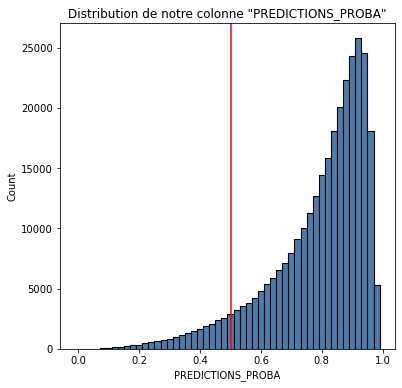

In [43]:
# Histrogramme de la distribution de la variable
plt.figure(figsize = (6, 6))
plt.hist(x = df_test['PREDICTIONS_PROBA'].values, bins = 50, align = 'left', color = '#4d7cab',
         edgecolor = 'black', linewidth = 1.1)
plt.axvline(x=0.5, color='r', label='axvline - full height')
plt.title('Distribution de notre colonne "PREDICTIONS_PROBA"')
plt.xlabel('PREDICTIONS_PROBA')
plt.ylabel('Count')
plt.show()

## Fonction test coût métier

In [45]:
# On crée une colonne pour nos tests
df_test['PREDICTIONS_TEST'] = df_test['PREDICTIONS']

In [66]:
def cout_metier(value=0.5):
    """
    """
    df_test.loc[df_test['PREDICTIONS_PROBA'] >= value, 'PREDICTIONS_TEST'] = 0
    df_test.loc[df_test['PREDICTIONS_PROBA'] < value, 'PREDICTIONS_TEST'] = 1
    
    matrix = confusion_matrix(df_test['TARGET'], df_test['PREDICTIONS_TEST'])

    false_neg = matrix[1, 0]
    false_pos = matrix[0, 1]
    total = df_test.shape[0]
    false_neg_error = round(false_neg / total*100, 2)
    false_pos_error = round(false_pos / total*100, 2)
    total_error = round(false_neg_error + false_pos_error, 2)
    
    print('False negative (ceux qui remboursent pas mais j\'ai dit que oui) :',
          false_neg_error, '%\n')
    print('False positive (ceux qui remboursent mais j\'ai dit que non) :',
          false_pos_error, '%')
    print('Erreur total =', total_error, '%')

In [73]:
cout_metier(0.6)

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 4.81 %

False positive (ceux qui remboursent mais j'ai dit que non) : 9.01 %
Erreur total = 13.82 %


In [77]:
for value in [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6]:
    print('Valeur =', value, '\n')
    cout_metier(value)
    print()
    print('-------------------------------')

Valeur = 0.5 

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 5.96 %

False positive (ceux qui remboursent mais j'ai dit que non) : 4.41 %
Erreur total = 10.37 %

-------------------------------
Valeur = 0.51 

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 5.85 %

False positive (ceux qui remboursent mais j'ai dit que non) : 4.75 %
Erreur total = 10.6 %

-------------------------------
Valeur = 0.52 

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 5.74 %

False positive (ceux qui remboursent mais j'ai dit que non) : 5.12 %
Erreur total = 10.86 %

-------------------------------
Valeur = 0.53 

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 5.62 %

False positive (ceux qui remboursent mais j'ai dit que non) : 5.51 %
Erreur total = 11.13 %

-------------------------------
Valeur = 0.54 

False negative (ceux qui remboursent pas mais j'ai dit que oui) : 5.52 %

False positive (ceux qui remboursent mais j'ai dit q

In [32]:
# # Matrice de confusion pour mieux voir nos erreurs
# matrix = confusion_matrix(df_test['TARGET'], df_test['PREDICTIONS'])

# ax = sns.heatmap(matrix, annot=True, cmap='Reds', fmt='g')

# ax.set_title('Confusion Matrix\n');
# ax.set_xlabel('\nCatégories prédites')
# ax.set_ylabel('Vraies catégories\n');

# # On ordonne nos catégories
# ax.xaxis.set_ticklabels([0, 1], rotation=90)
# ax.yaxis.set_ticklabels([0, 1], rotation=0)

# plt.show()